# 📘 Grammar Scoring System using ASR and NLP
This notebook demonstrates a system that evaluates spoken grammar using:
- Automatic Speech Recognition (Wav2Vec2)
- Audio features (via Librosa)
- Text-based NLP features (via NLTK, LanguageTool)
- Regression models to score grammar quality.


## 🔧 Setup
Install dependencies and Java (for LanguageTool).

In [4]:
!pip install language-tool-python
!apt-get update
!apt-get install openjdk-17-jdk -y
!pip install nltk==3.8.1 --quiet
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 255 kB in 5s (47.1 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 📚 Imports
Import libraries for audio processing, NLP, modeling, and evaluation.

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import scipy
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
import language_tool_python
import re
import warnings
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.17.0-openjdk-amd64"

warnings.filterwarnings('ignore')


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def count_syllables_helper(word):
    """Helper function to count syllables using regex"""
    word = word.lower()
    word = re.sub(r'[^a-z]', '', word)
    word = re.sub(r'[eaoui][eaoui]', 'a', word)
    word = re.sub(r'e$', '', word)
    vowels = re.findall(r'[eaoui][^eaoui]', word)
    vowels += re.findall(r'[eaoui]$', word)
    vowels += re.findall(r'^[^eaoui]y', word)
    vowels += re.findall(r'[^eaoui]y[^eaoui]', word)
    if word.startswith('mc'): vowels.append(1)
    count = len(vowels)
    if len(word) <= 2: count = 1
    return max(1, count)

def count_syllables(word):
    """Count syllables in a word"""
    word = word.lower()
    exception_add = ['serious', 'crucial']
    exception_del = ['fortunately', 'unfortunately']
    co_one = ['cool', 'coach', 'coat', 'coal', 'count', 'coin', 'coarse', 'coup', 'coif', 'cook', 'coign', 'coiffe', 'coof', 'court']
    co_two = ['coapt', 'coed', 'coinci']
    pre_one = ['preach']

    if word in exception_add: return count_syllables_helper(word) + 1
    elif word in exception_del: return count_syllables_helper(word) - 1
    elif word in co_one: return 1
    elif word in co_two: return 2
    elif word in pre_one: return 1
    else: return count_syllables_helper(word)

## 📚 Imports
Import libraries for audio processing, NLP, modeling, and evaluation.

In [11]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
import language_tool_python
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from joblib import dump, load
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

def count_syllables(word):
    """Count the number of syllables in a word."""
    word = word.lower()
    if len(word) <= 3:
        return 1
    vowels = "aeiouy"
    count = 0
    prev_is_vowel = False
    for char in word:
        is_vowel = char in vowels
        if is_vowel and not prev_is_vowel:
            count += 1
        prev_is_vowel = is_vowel
    if word.endswith('e'):
        count -= 1
    if word.endswith('le') and len(word) > 2 and word[-3] not in vowels:
        count += 1
    return max(1, count)

class GrammarScoringSystem:
    def __init__(self, data_path='./', use_cache=True, sample_size=None):
        """Initialize the Optimized Grammar Scoring System"""
        self.data_path = data_path
        self.use_cache = use_cache
        self.sample_size = sample_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.language_tool = None  # Will be initialized only when needed
        self.processor = None      # Will be initialized only when needed
        self.asr_model = None      # Will be initialized only when needed

        # Storage for features and models
        self.audio_features = {}
        self.text_features = {}
        self.combined_features = {}
        self.model = None
        self.predictions = None
        self.skipped_files = []
        self.skipped_test_files = []

        # Cache file paths
        self.cache_dir = os.path.join(data_path, 'cache')
        os.makedirs(self.cache_dir, exist_ok=True)

        # Cache file paths
        self.features_cache = os.path.join(self.cache_dir, 'features.pkl')
        self.model_cache = os.path.join(self.cache_dir, 'model.joblib')
        self.transcription_cache = os.path.join(self.cache_dir, 'transcriptions.pkl')

        # Transcription cache
        self.transcriptions = {}
        if self.use_cache and os.path.exists(self.transcription_cache):
            try:
                with open(self.transcription_cache, 'rb') as f:
                    self.transcriptions = pickle.load(f)
                print(f"Loaded {len(self.transcriptions)} cached transcriptions")
            except Exception as e:
                print(f"Error loading transcription cache: {e}")

    def _initialize_language_tool(self):
        """Initialize LanguageTool on demand"""
        if self.language_tool is None:
            print("Initializing LanguageTool...")
            self.language_tool = language_tool_python.LanguageTool('en-US')

    def _initialize_asr_model(self):
        """Initialize ASR model on demand"""
        if self.processor is None or self.asr_model is None:
            print("Initializing ASR model...")
            self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
            self.asr_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(self.device)

    def load_data(self):
        """Load the dataset with optional sampling"""
        print("Loading data...")
        self.sampl_size=10;
        # Load full datasets
        train_path = os.path.join(self.data_path, 'train.csv')
        test_path = os.path.join(self.data_path, 'test.csv')

        if not os.path.exists(train_path) or not os.path.exists(test_path):
            raise FileNotFoundError(f"Training or test data not found at {self.data_path}")

        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)

        # Sample if specified
        if self.sample_size:
            self.train_df = train_df.sample(n=min(self.sample_size, len(train_df)), random_state=42)
            self.test_df = test_df.sample(n=min(self.sample_size//3, len(test_df)), random_state=42)
        else:
            self.train_df = train_df
            self.test_df = test_df

        print(f"Loaded {len(self.train_df)} training samples and {len(self.test_df)} test samples")

        # Generate grammar scores if needed
        if 'grammar_score' not in self.train_df.columns:
            print("No grammar_score column found in training data. Generating grammar scores...")
            self._generate_grammar_scores()

        print("\nTraining data overview:")
        print(self.train_df.head())

        return self.train_df, self.test_df

    def _generate_grammar_scores(self):
        """Generate grammar scores for training data"""
        self._initialize_language_tool()

        scores = []
        for idx, row in self.train_df.iterrows():
            audio_path = os.path.join(self.data_path, 'audios', 'train', row['filename'])
            if not os.path.exists(audio_path):
                print(f"Warning: File not found: {audio_path}. Skipping.")
                scores.append(None)
                continue

            transcript = self.transcribe_audio(audio_path)
            score = self.compute_grammar_score(transcript)
            scores.append(score)

            # Print progress
            if idx % 10 == 0:
                print(f"Processed {idx}/{len(self.train_df)} files for grammar scoring")

        self.train_df['grammar_score'] = scores
        # Drop rows with None scores (from missing files)
        self.train_df = self.train_df.dropna(subset=['grammar_score']).reset_index(drop=True)
        print(f"Training data after removing missing files: {len(self.train_df)} samples")

    def transcribe_audio(self, file_path):
        """Transcribe audio with caching"""
        if not os.path.exists(file_path):
            return ""

        # Check cache first
        if file_path in self.transcriptions:
            return self.transcriptions[file_path]

        try:
            self._initialize_asr_model()

            # Load and prepare audio
            speech_array, sampling_rate = torchaudio.load(file_path)
            if sampling_rate != 16000:
                resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
                speech_array = resampler(speech_array)

            # Handle multiple channels
            if speech_array.shape[0] > 1:
                speech_array = torch.mean(speech_array, dim=0, keepdim=True)

            # Process through ASR model
            speech_array = speech_array.squeeze().numpy()
            inputs = self.processor(speech_array, sampling_rate=16000, return_tensors="pt", padding=True)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                logits = self.asr_model(**inputs).logits

            # Decode transcription
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = self.processor.batch_decode(predicted_ids)[0]

            # Cache the result
            self.transcriptions[file_path] = transcription

            # Periodically save the cache
            if len(self.transcriptions) % 10 == 0 and self.use_cache:
                with open(self.transcription_cache, 'wb') as f:
                    pickle.dump(self.transcriptions, f)

            return transcription

        except Exception as e:
            print(f"Error transcribing file {file_path}: {str(e)}")
            return ""

    def compute_grammar_score(self, text):
        """Compute grammar score based on error rate"""
        if not text:
            return None

        try:
            self._initialize_language_tool()
            matches = self.language_tool.check(text)
            num_errors = len(matches)
            num_words = len(text.split())

            # Error rate per 100 words
            error_rate = (num_errors / max(num_words, 1)) * 100

            # Assign grammar score based on error rate
            if error_rate > 20:
                return 1
            elif error_rate > 15:
                return 2
            elif error_rate > 10:
                return 3
            elif error_rate > 5:
                return 4
            else:
                return 5

        except Exception as e:
            print(f"Error computing grammar score: {str(e)}")
            return None

    def process_audio(self, file_path):
        """Process audio and extract features"""
        if not os.path.exists(file_path):
            return None

        try:
            # Load and resample audio
            audio, sample_rate = librosa.load(file_path, sr=16000, mono=True, res_type='kaiser_fast')

            # Initialize features dictionary
            features = {}

            # Basic features - prioritize the ones with highest correlation
            features['duration'] = librosa.get_duration(y=audio, sr=sample_rate)

            # Energy features
            rms = librosa.feature.rms(y=audio)[0]
            features['rms_mean'] = np.mean(rms)
            features['rms_std'] = np.std(rms)

            # Spectral features (only essential ones)
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)[0]
            features['spectral_centroid_mean'] = np.mean(spectral_centroid)

            # ZCR - Good for detecting speech characteristics
            zcr = librosa.feature.zero_crossing_rate(audio)[0]
            features['zcr_mean'] = np.mean(zcr)

            # MFCCs - Just a few of the most informative ones
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=5)
            for i in range(5):
                features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])

            # Silence detection (simplified)
            frame_length, hop_length = 2048, 512
            energy = np.array([sum(abs(audio[i:i+frame_length]**2))
                              for i in range(0, len(audio), hop_length)])
            silence_threshold = np.mean(energy) * 0.1
            silences = np.where(energy < silence_threshold)[0]
            features['silence_rate'] = len(silences) / len(energy)

            if len(silences) > 1:
                silence_lengths = []
                current_silence = [silences[0]]

                for i in range(1, len(silences)):
                    if silences[i] == silences[i-1] + 1:
                        current_silence.append(silences[i])
                    else:
                        silence_lengths.append(len(current_silence))
                        current_silence = [silences[i]]

                if current_silence:
                    silence_lengths.append(len(current_silence))

                features['mean_silence_length'] = np.mean(silence_lengths) if silence_lengths else 0
                features['num_silences'] = len(silence_lengths)
            else:
                features['mean_silence_length'] = 0
                features['num_silences'] = 0

            return features

        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")
            return None

    def extract_text_features(self, text):
        """Extract linguistic features from text"""
        if not text:
            return None

        try:
            self._initialize_language_tool()
            features = {}

            # Clean text
            text = text.lower()
            text = re.sub(r'[^\w\s]', '', text)

            # Basic text statistics
            words = word_tokenize(text)
            sentences = sent_tokenize(text)

            features['word_count'] = len(words)
            features['sentence_count'] = max(1, len(sentences))
            features['avg_words_per_sentence'] = len(words) / features['sentence_count']

            # Vocabulary richness
            features['unique_words'] = len(set(words))
            features['lexical_diversity'] = features['unique_words'] / max(1, len(words))

            # Word length statistics
            word_lengths = [len(word) for word in words]
            features['avg_word_length'] = np.mean(word_lengths) if word_lengths else 0

            # Grammar check
            grammar_matches = self.language_tool.check(text)
            features['grammar_error_count'] = len(grammar_matches)
            features['grammar_error_rate'] = len(grammar_matches) / max(1, len(words))

            # Error types
            error_categories = {}
            for match in grammar_matches:
                category = match.category
                error_categories[category] = error_categories.get(category, 0) + 1

            features['spelling_errors'] = error_categories.get('SPELLING', 0)
            features['grammar_errors'] = error_categories.get('GRAMMAR', 0)
            features['punctuation_errors'] = error_categories.get('PUNCTUATION', 0)

            # Simple readability metric
            if words and sentences:
                features['avg_sentence_length'] = np.mean([len(sent.split()) for sent in sentences])
                features['fk_grade'] = 0.39 * (len(words) / len(sentences)) + 11.8 * (sum(count_syllables(word) for word in words) / len(words)) - 15.59
            else:
                features['avg_sentence_length'] = 0
                features['fk_grade'] = 0

            return features

        except Exception as e:
            print(f"Error extracting text features: {str(e)}")
            return None

    def extract_features(self, is_training=True):
        """Extract features with caching strategy"""
        dataset_type = "training" if is_training else "test"
        print(f"Extracting features from {dataset_type} dataset...")

        # Check if cached features exist
        cache_file = f"{self.cache_dir}/{dataset_type}_features.pkl"
        if self.use_cache and os.path.exists(cache_file):
            print(f"Loading cached {dataset_type} features...")
            try:
                with open(cache_file, 'rb') as f:
                    if is_training:
                        self.train_features_df = pickle.load(f)
                        print(f"Loaded {len(self.train_features_df)} cached training features")
                        return self.train_features_df
                    else:
                        self.test_features_df = pickle.load(f)
                        print(f"Loaded {len(self.test_features_df)} cached test features")
                        return self.test_features_df
            except Exception as e:
                print(f"Error loading cached features: {e}")

        # If no cache, extract features
        df = self.train_df if is_training else self.test_df
        folder_type = "train" if is_training else "test"
        skipped_files = []
        features_dict = {}

        batch_size = 10  # Process in small batches to allow checkpointing
        for batch_start in range(0, len(df), batch_size):
            batch_end = min(batch_start + batch_size, len(df))
            print(f"Processing batch {batch_start//batch_size + 1}/{(len(df) + batch_size - 1)//batch_size}")

            for idx in range(batch_start, batch_end):
                row = df.iloc[idx]
                file_name = row['filename']
                file_path = os.path.join(self.data_path, 'audios', folder_type, file_name)

                if not os.path.exists(file_path):
                    print(f"Warning: File not found: {file_path}. Skipping.")
                    skipped_files.append(file_name)
                    continue

                print(f"  Processing file {idx+1}/{len(df)}: {file_name}")

                try:
                    # Extract features
                    audio_features = self.process_audio(file_path)
                    if audio_features is None:
                        print(f"  Warning: Could not process audio for {file_name}. Skipping.")
                        skipped_files.append(file_name)
                        continue

                    transcript = self.transcribe_audio(file_path)
                    text_features = self.extract_text_features(transcript)
                    if text_features is None:
                        print(f"  Warning: Could not extract text features for {file_name}. Skipping.")
                        skipped_files.append(file_name)
                        continue

                    # Combine features
                    features_dict[file_name] = {**audio_features, **text_features}

                except Exception as e:
                    print(f"  Error processing {file_name}: {str(e)}. Skipping.")
                    skipped_files.append(file_name)
                    continue

            # Save intermediate results
            if self.use_cache and batch_end % (batch_size * 5) == 0:
                with open(f"{self.cache_dir}/{dataset_type}_features_intermediate.pkl", 'wb') as f:
                    pickle.dump(features_dict, f)
                print(f"Saved intermediate features for {len(features_dict)} files")

        # Create DataFrame from features
        features_df = pd.DataFrame.from_dict(features_dict, orient='index')

        # Filter out skipped files
        valid_files = [f for f in df['filename'] if f not in skipped_files]
        filtered_df = df[df['filename'].isin(valid_files)].copy()

        # Join features with original dataframe
        result_df = filtered_df.set_index('filename').join(features_df)

        # Save to cache
        if self.use_cache:
            with open(cache_file, 'wb') as f:
                pickle.dump(result_df, f)
            print(f"Saved {dataset_type} features to cache")

        # Store results
        if is_training:
            self.train_features_df = result_df
            self.skipped_files = skipped_files
        else:
            self.test_features_df = result_df
            self.skipped_test_files = skipped_files

        print(f"Extracted {features_df.shape[1]} features from {len(features_dict)} files")
        print(f"Skipped {len(skipped_files)} files")

        return result_df

    def analyze_features(self):
        """Analyze extracted features"""
        print("Analyzing features...")

        if not hasattr(self, 'train_features_df') or self.train_features_df.empty:
            print("No features to analyze. Extract features first.")
            return

        # Handle missing values
        missing_values = self.train_features_df.isnull().sum()
        print("\nMissing values in features:")
        print(missing_values[missing_values > 0])
        self.train_features_df = self.train_features_df.fillna(0)

        # Feature correlations with target
        if 'grammar_score' in self.train_features_df.columns:
            feature_cols = self.train_features_df.columns.drop('grammar_score')
            corr_with_target = self.train_features_df[feature_cols].corrwith(self.train_features_df['grammar_score']).sort_values(ascending=False)

            print("\nTop features correlated with grammar score:")
            print(corr_with_target.head(10))
            print("\nBottom features correlated with grammar score:")
            print(corr_with_target.tail(10))

            # Plot correlation heatmap
            plt.figure(figsize=(12, 10))
            top_features = corr_with_target.abs().sort_values(ascending=False).head(10).index
            correlation_matrix = self.train_features_df[list(top_features) + ['grammar_score']].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Correlation Heatmap for Top Features')
            plt.tight_layout()
            plt.show()

            # Target distribution
            plt.figure(figsize=(10, 6))
            sns.histplot(self.train_features_df['grammar_score'], bins=10, kde=True)
            plt.title('Distribution of Grammar Scores')
            plt.xlabel('Grammar Score')
            plt.ylabel('Frequency')
            plt.show()

    def train_model(self):
        """Train regression model with caching"""
        print("Training models...")

        # Check if we can load a cached model
        if self.use_cache and os.path.exists(self.model_cache):
            print("Loading cached model...")
            try:
                self.model = load(self.model_cache)
                print("Model loaded from cache")
                return {"message": "Model loaded from cache"}
            except Exception as e:
                print(f"Error loading cached model: {e}")

        if not hasattr(self, 'train_features_df') or self.train_features_df.empty:
            print("No data available for training. Extract features first.")
            return None

        # Prepare data
        features = self.train_features_df.drop('grammar_score', axis=1)
        target = self.train_features_df['grammar_score']

        if len(features) < 2:
            print("Not enough data available for training after skipping files.")
            return None

        X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

        # Models to test - using fewer models for faster training
        models = {
            'Ridge': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
        }

        # Evaluate models
        best_model, best_score, results = None, float('inf'), {}

        for name, model in models.items():
            print(f"\nTraining {name}...")

            # Create pipeline with scaling
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])

            # Cross-validation
            start_time = time.time()
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
            cv_rmse = np.sqrt(-cv_scores).mean()

            # Fit and evaluate
            pipeline.fit(X_train, y_train)
            val_preds = pipeline.predict(X_val)
            val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
            val_mae = mean_absolute_error(y_val, val_preds)
            val_r2 = r2_score(y_val, val_preds)

            print(f"{name} - Time: {time.time() - start_time:.2f}s, CV RMSE: {cv_rmse:.4f}, Val RMSE: {val_rmse:.4f}, Val R²: {val_r2:.4f}")

            results[name] = {
                'cv_rmse': cv_rmse,
                'val_rmse': val_rmse,
                'val_mae': val_mae,
                'val_r2': val_r2,
                'pipeline': pipeline
            }

            # Track best model
            if val_rmse < best_score:
                best_score, best_model = val_rmse, name

        if best_model is None:
            print("Model training failed. No best model selected.")
            return None

        # Use best model
        print(f"\nBest model: {best_model} with RMSE: {results[best_model]['val_rmse']:.4f}")
        self.model = results[best_model]['pipeline']

        # Refit on all training data
        self.model.fit(features, target)

        # Save model to cache
        if self.use_cache:
            dump(self.model, self.model_cache)
            print(f"Saved model to {self.model_cache}")

        # Feature importance for Random Forest
        if best_model == 'Random Forest':
            feature_importance = self.model.named_steps['model'].feature_importances_
            feature_names = features.columns
            indices = np.argsort(feature_importance)[::-1]

            # Plot top 10 feature importances
            plt.figure(figsize=(12, 6))
            plt.title('Feature Importances')
            plt.bar(range(len(indices[:10])), feature_importance[indices[:10]], align='center')
            plt.xticks(range(len(indices[:10])), [feature_names[i] for i in indices[:10]], rotation=90)
            plt.tight_layout()
            plt.show()

            print("\nTop 10 important features:")
            for i in range(min(10, len(indices))):
                print(f"{feature_names[indices[i]]}: {feature_importance[indices[i]]:.4f}")

        return results

    def make_predictions(self):
        """Make predictions on test set"""
        print("Making predictions on test set...")

        if self.model is None:
            print("No trained model available. Train a model first.")
            return None

        if not hasattr(self, 'test_features_df') or self.test_features_df.empty:
            print("No test data available. Extract test features first.")
            return None

        # Check and conform test features to match training features
        train_columns = self.train_features_df.drop('grammar_score', axis=1).columns

        # Ensure test data has same columns as training data
        for col in train_columns:
            if col not in self.test_features_df.columns:
                self.test_features_df[col] = 0

        # Use only the columns from training
        X_test = self.test_features_df[train_columns]

        # Predict and clip values to valid range
        self.predictions = self.model.predict(X_test)
        self.predictions = np.clip(self.predictions, 0, 5)

        # Save predictions
        submission_df = pd.DataFrame({
            'filename': self.test_features_df.index,
            'grammar_score': self.predictions
        })

        # Handle skipped files
        if self.skipped_test_files:
            print(f"Adding default predictions for {len(self.skipped_test_files)} skipped files")
            default_score = self.train_features_df['grammar_score'].mean()
            skipped_df = pd.DataFrame({
                'filename': self.skipped_test_files,
                'grammar_score': [default_score] * len(self.skipped_test_files)
            })
            submission_df = pd.concat([submission_df, skipped_df], ignore_index=True)

        # Save to CSV
        submission_path = os.path.join(self.data_path, 'submission.csv')
        submission_df.to_csv(submission_path, index=False)
        print(f"Predictions saved to {submission_path}")

        # Plot distribution of predictions
        plt.figure(figsize=(10, 6))
        sns.histplot(self.predictions, bins=10, kde=True)
        plt.title('Distribution of Predicted Grammar Scores')
        plt.xlabel('Predicted Grammar Score')
        plt.ylabel('Frequency')
        plt.show()

        return submission_df

    def run_pipeline(self, extract_features=True, train=True, predict=True, analyze=True, sample_size=None):
        """Run the full pipeline with appropriate caching"""
        start_time = time.time()

        print(f"Running pipeline with device: {self.device}")

        # Update sample size if provided
        if sample_size:
            self.sample_size = sample_size

        # Load data
        self.load_data()

        # Extract features if requested
        if extract_features:
            train_features = self.extract_features(is_training=True)
            if train_features is None:
                print("Failed to extract training features, stopping pipeline")
                return

            test_features = self.extract_features(is_training=False)
            if test_features is None:
                print("Failed to extract test features, stopping pipeline")
                return

        # Analyze features if requested
        if analyze:
            self.analyze_features()

        # Train model if requested
        if train:
            model_results = self.train_model()
            if model_results is None:
                print("Failed to train model, stopping pipeline")
                return

        # Make predictions if requested
        if predict:
            predictions = self.make_predictions()
            if predictions is None:
                print("Failed to make predictions")
                return

        total_time = time.time() - start_time
        print(f"Pipeline completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        return True

### 📌 Display Predicted Grammar Score
This section clips the predicted grammar score between 0 and 5 using `np.clip()` to ensure it stays within
valid bounds. Then it converts the result to an integer (removing decimal places) and prints it. This makes
the output more user-friendly, especially for UI or report generation.

Loaded 440 cached transcriptions
Loading data...
Loaded 444 training samples and 204 test samples
No grammar_score column found in training data. Generating grammar scores...
Initializing LanguageTool...
Processed 0/444 files for grammar scoring
Processed 10/444 files for grammar scoring
Processed 20/444 files for grammar scoring
Processed 30/444 files for grammar scoring
Processed 40/444 files for grammar scoring
Processed 50/444 files for grammar scoring
Processed 60/444 files for grammar scoring
Processed 70/444 files for grammar scoring
Processed 80/444 files for grammar scoring
Processed 90/444 files for grammar scoring
Processed 100/444 files for grammar scoring
Processed 110/444 files for grammar scoring
Processed 120/444 files for grammar scoring
Processed 130/444 files for grammar scoring
Processed 140/444 files for grammar scoring
Processed 150/444 files for grammar scoring
Processed 160/444 files for grammar scoring
Processed 170/444 files for grammar scoring
Processed 180/4

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed 440/444 files for grammar scoring
Training data after removing missing files: 444 samples

Training data overview:
         filename  label  grammar_score
0   audio_710.wav    1.0              1
1  audio_1265.wav    1.0              1
2  audio_1114.wav    1.5              1
3   audio_946.wav    1.5              3
4  audio_1127.wav    2.0              3
Extracting features from training dataset...
Loading cached training features...
Loaded 444 cached training features
Analyzing features...

Missing values in features:
Series([], dtype: int64)

Top features correlated with grammar score:
avg_sentence_length       0.481510
avg_words_per_sentence    0.481402
word_count                0.481402
fk_grade                  0.462923
spectral_centroid_mean    0.386916
zcr_mean                  0.369141
unique_words              0.337441
punctuation_errors        0.257648
grammar_errors            0.228355
mfcc1_mean                0.217622
dtype: float64

Bottom features correlated with

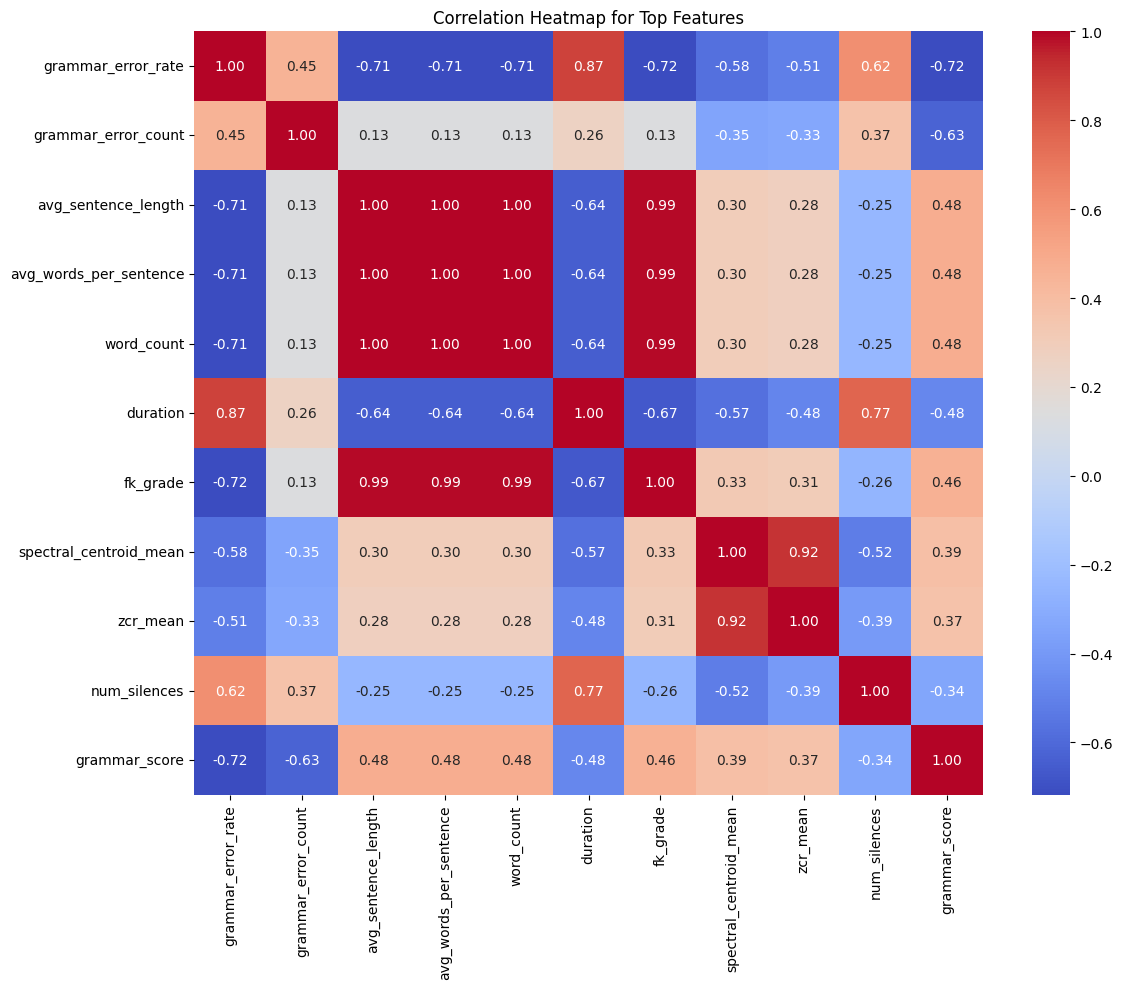

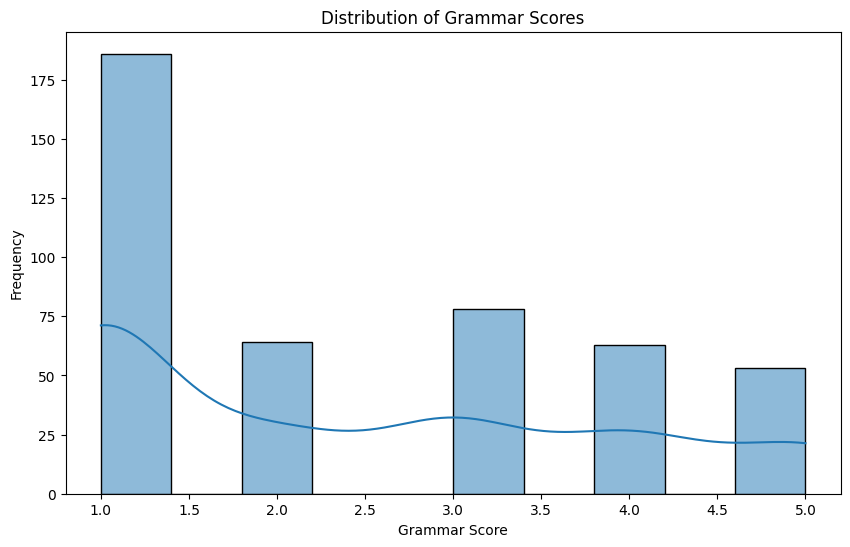

Training models...

Training Ridge...
Ridge - Time: 0.08s, CV RMSE: 0.7162, Val RMSE: 0.7842, Val R²: 0.7153

Training Random Forest...
Random Forest - Time: 1.71s, CV RMSE: 0.5219, Val RMSE: 0.4943, Val R²: 0.8869

Best model: Random Forest with RMSE: 0.4943
Saved model to /content/drive/MyDrive/untitled folder 3/Dataset/cache/model.joblib


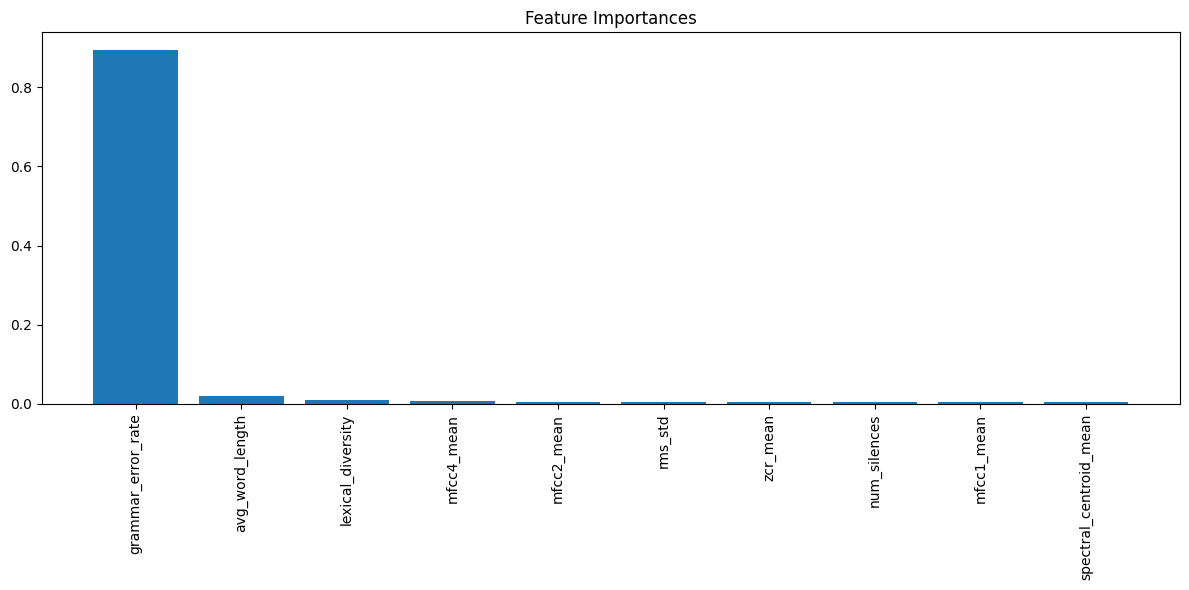


Top 10 important features:
grammar_error_rate: 0.8938
avg_word_length: 0.0200
lexical_diversity: 0.0105
mfcc4_mean: 0.0063
mfcc2_mean: 0.0060
rms_std: 0.0058
zcr_mean: 0.0057
num_silences: 0.0047
mfcc1_mean: 0.0047
spectral_centroid_mean: 0.0044
Making predictions on test set...
No test data available. Extract test features first.


In [14]:
# Initialize and run the system
scoring_system = GrammarScoringSystem(data_path='/content/drive/MyDrive/untitled folder 3/Dataset')

# Load data
scoring_system.load_data()

# Extract features
scoring_system.extract_features()


# Analyze features
scoring_system.analyze_features()

# Train model
model_results = scoring_system.train_model()

# Make predictions
submission = scoring_system.make_predictions()

In [19]:
# Example with a single audio file
file_path = "/content/drive/MyDrive/untitled folder 3/Dataset/audios/test/audio_1001.wav"  # Replace with actual path

# Process audio and extract features
audio_features = scoring_system.process_audio(file_path)
print("Audio features extracted:", list(audio_features.keys()))

# Transcribe audio
transcript = scoring_system.transcribe_audio(file_path)
print("Transcription:", transcript)

# Extract text features
text_features = scoring_system.extract_text_features(transcript)
print("Text features extracted:", list(text_features.keys()))

# Predict grammar score
combined_features = {**audio_features, **text_features}
feature_df = pd.DataFrame([combined_features])

# Align columns with training data
train_columns = scoring_system.train_features_df.drop('grammar_score', axis=1).columns
for col in set(train_columns) - set(feature_df.columns):
    feature_df[col] = 0
feature_df = feature_df[train_columns]

# Make prediction
prediction = scoring_system.model.predict(feature_df)[0]
print(f"Predicted grammar score: {int(np.clip(prediction, 0, 5))}")


Audio features extracted: ['duration', 'rms_mean', 'rms_std', 'spectral_centroid_mean', 'zcr_mean', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean', 'silence_rate', 'mean_silence_length', 'num_silences']
Transcription: THE SCHOOL PLAYGROUND LOOKS PRETTY BIG THEREARE A LOT OF KITS AROUND THERE IS THI STRUCSHURE ABOVE THE SLIDE WHERE IT'S A BIG OPEN AREA ALL THE KIDS ARE PLAYING I SEE A METAL POLE ATTACHED TO THI STRUCKSHURE TO SEE A YELLOW SLIDE AH REPLACE FROM THE METAL SLIDES THAT WERE VERY HARSH TO SLIDE DOWN AH THE SEA SAW IS ONE OF THE FAVOURITE ACTIVITIES AMONG THE STUDENTS THERE'S A LOT OF LAUGHING AH SCREAMING YELLING AMONGST THE STUDENTS IN THE SCHOOLPLAY GROUND AND THERE IS BARK ON THE FLOOR
Text features extracted: ['word_count', 'sentence_count', 'avg_words_per_sentence', 'unique_words', 'lexical_diversity', 'avg_word_length', 'grammar_error_count', 'grammar_error_rate', 'spelling_errors', 'grammar_errors', 'punctuation_errors', 'avg_sentence_length', 'f

### 📌 Display Predicted Grammar Score
This section clips the predicted grammar score between 0 and 5 using `np.clip()` to ensure it stays within
valid bounds. Then it converts the result to an integer (removing decimal places) and prints it. This makes
the output more user-friendly, especially for UI or report generation.